In [0]:
!pip install pyspark

     |▍    

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 281.4 MB 3.4 kB/s 
     |████████████████████████████████| 199 kB 82.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=fd05439962f33a65332b20b1984b1f12fd0b33b3f72229929c888327905326ba
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-fd9b1da3-60a6-4ac0-adc4-319f8ffe62b1/bin/python -m pip install --upgrade pip' command.


In [0]:
pip install PyArrow

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pandas as pd
import pyspark.pandas as ps

In [0]:
from pyspark.sql import SparkSession

# Create a SparkSession with a local master
spark = SparkSession.builder.appName("UberEDA").master("local[*]").getOrCreate()

# Read a CSV file from the local file system
df = spark.read.load("dbfs:/user/hive/warehouse/train_new")



In [0]:
df.show()

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:42|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|        5.3|2

In [0]:
num_rows = df.count()
num_cols = len(df.columns)


In [0]:
print(num_rows)
print(num_cols)

500000
8


In [0]:
df.show()


+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+----+-----+----+---+----+------------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|date|month|year|day|hour|          Distance|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+----+-----+----+---+----+------------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 00:00:00|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|  15|    6|2009|  2|   0|1030.7639350492534|
|2010-01-05 16:52:16|       16.9|2010-01-05 00:00:00|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|   5|    1|2010|  3|   0|  8450.13359580609|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:00:00|      -73.982738|       40.76127|    

In [0]:
df = df.drop('key')


In [0]:
df.show()

+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+----+-----+----+---+----+------------------+
|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|date|month|year|day|hour|          Distance|
+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+----+-----+----+---+----+------------------+
|        4.5|2009-06-15 00:00:00|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|  15|    6|2009|  2|   0|1030.7639350492534|
|       16.9|2010-01-05 00:00:00|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|   5|    1|2010|  3|   0|  8450.13359580609|
|        5.7|2011-08-18 00:00:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|  18|    8|2011|  5|   0|1389.5252257699267|
|        7.7|2012-04-21 00:0

In [0]:
from pyspark.sql.functions import isnull, col

# create a list of column names and their corresponding null value count
null_counts = [(column, df.filter(isnull(col(column))).count()) for column in df.columns]

# convert the list into a PySpark DataFrame
nvc = spark.createDataFrame(null_counts, ['Column', 'Total Null Values'])

# calculate the percentage of null values for each column
nvc = nvc.withColumn('Percentage', round(nvc['Total Null Values'] / df.count() * 100, 2))

# show the results
nvc.show()



+-----------------+-----------------+----------+
|           Column|Total Null Values|Percentage|
+-----------------+-----------------+----------+
|      fare_amount|                0|       0.0|
|  pickup_datetime|                0|       0.0|
| pickup_longitude|                0|       0.0|
|  pickup_latitude|                0|       0.0|
|dropoff_longitude|                0|       0.0|
| dropoff_latitude|                0|       0.0|
|  passenger_count|                0|       0.0|
|             date|                0|       0.0|
|            month|                0|       0.0|
|             year|                0|       0.0|
|              day|                0|       0.0|
|             hour|                0|       0.0|
|         Distance|                0|       0.0|
+-----------------+-----------------+----------+



In [0]:
df = df.dropna()

In [0]:
print("Rows:", df.count())
print("Columns:", len(df.columns))

Rows: 500000
Columns: 8


In [0]:
%pip install geopy

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# import required libraries
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DoubleType
from geopy import distance
from pyspark.sql.functions import lit, round

# Define a UDF to calculate distance using geopy
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radius of the Earth in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance_m = R * c
    return distance_m

# Register the UDF with Spark
calc_distance_udf = udf(haversine, DoubleType())

# filter out invalid coordinates
min_lat = -90
max_lat = 90
min_long = -180
max_long = 180
df = df.filter((df.pickup_longitude >= min_long) & (df.pickup_longitude <= max_long))
df = df.filter((df.dropoff_longitude >= min_long) & (df.dropoff_longitude <= max_long))
df = df.filter((df.pickup_latitude >= min_lat) & (df.pickup_latitude <= max_lat))
df = df.filter((df.dropoff_latitude >= min_lat) & (df.dropoff_latitude <= max_lat))

# convert 'pickup_datetime' to datetime format
df = df.withColumn('pickup_datetime', to_timestamp('pickup_datetime'))

# extract date, month, year, day, and hour from pickup_datetime
df = df.withColumn('date', dayofmonth('pickup_datetime').cast(IntegerType()))
df = df.withColumn('month', month('pickup_datetime').cast(IntegerType()))
df = df.withColumn('year', year('pickup_datetime').cast(IntegerType()))
df = df.withColumn('day', dayofweek('pickup_datetime').cast(IntegerType()))
df = df.withColumn('hour', hour('pickup_datetime').cast(IntegerType()))

# Calculate distance using the UDF and assign to 'Distance' column
df = df.withColumn('Distance', calc_distance_udf(col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude')))


/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


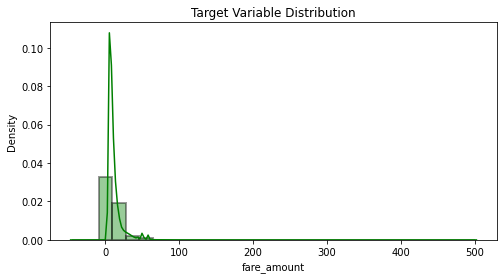

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark dataframe to Pandas dataframe
pdf = df.select('fare_amount').toPandas()

# Plot the distribution using Seaborn
plt.figure(figsize=[8,4])
sns.distplot(pdf['fare_amount'], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution')
plt.show()


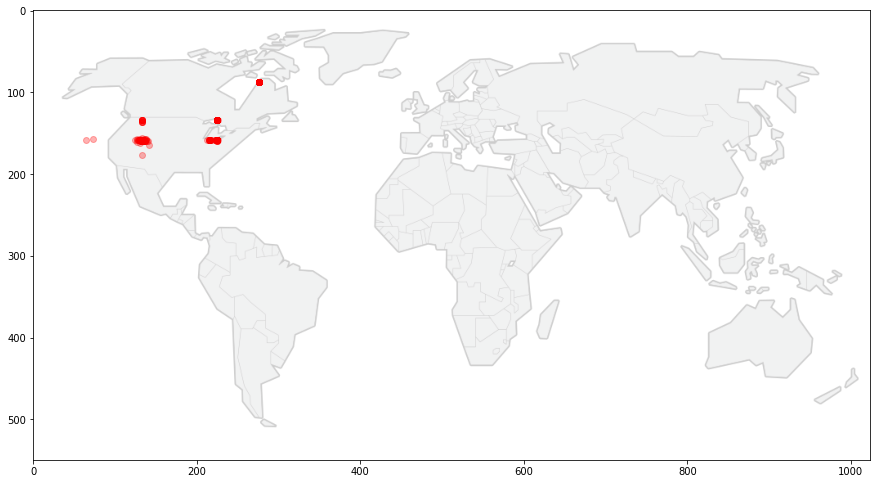

In [0]:
import matplotlib.pyplot as plt
import urllib.request
from pyspark.sql.functions import col

# read the image from the URL
url = 'https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/wm.png'
with urllib.request.urlopen(url) as url:
    s = url.read()

# save the image to a file
with open('wm.png', 'wb') as f:
    f.write(s)

# plot the image and scatter plot
plt.figure(figsize=[15,10])
img = plt.imread('wm.png')
plt.imshow(img, alpha=0.2)
df = df.filter(col('pickup_longitude').isNotNull() & col('pickup_latitude').isNotNull())
df_plot = df.select((col('pickup_longitude')+180)*1.25, (col('pickup_latitude')+215)*0.62)
df_plot = df_plot.toPandas()
plt.scatter(df_plot.iloc[:,0], df_plot.iloc[:,1], alpha=0.3, color='red')
plt.show()


In [0]:

plt.figure(figsize=[8,4])
sns.distplot(data['fare_amount'], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

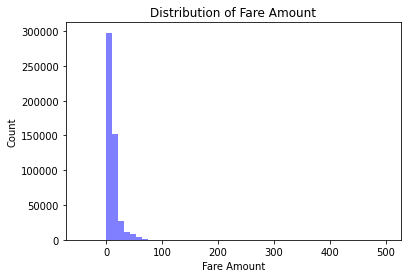

In [0]:
df.select('fare_amount').rdd.flatMap(lambda x: x).histogram(10)
plt.hist(df.select('fare_amount').rdd.flatMap(lambda x: x).collect(), bins=50, color='blue', alpha=0.5)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Count')
plt.show()


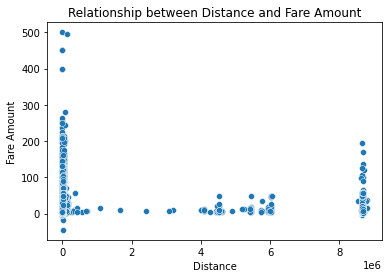

In [0]:
import seaborn as sns
sns.scatterplot(x='Distance', y='fare_amount', data=df.toPandas())
plt.title('Relationship between Distance and Fare Amount')
plt.xlabel('Distance')
plt.ylabel('Fare Amount')
plt.show()


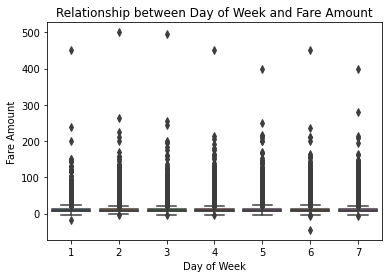

In [0]:
sns.boxplot(x='day', y='fare_amount', data=df.toPandas())
plt.title('Relationship between Day of Week and Fare Amount')
plt.xlabel('Day of Week')
plt.ylabel('Fare Amount')
plt.show()


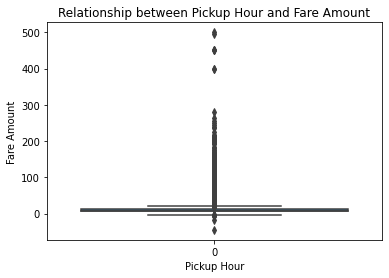

In [0]:
sns.boxplot(x='hour', y='fare_amount', data=df.toPandas())
plt.title('Relationship between Pickup Hour and Fare Amount')
plt.xlabel('Pickup Hour')
plt.ylabel('Fare Amount')
plt.show()